<a href="https://colab.research.google.com/github/yasirabd/research-diagnostic-turbine/blob/main/Prognostics_Turbine_Bearing_1_Local_Bearing_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Date: 14 Desember 2021*<br>
*Author: Yasir Abdur Rohman*<br>
**Property of PT Indonesia Power & Lab Getaran & Diagnosis Mesin Undip**

---

# Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
from scipy.spatial import distance

from sklearn.metrics import mean_squared_error

# Load Data

In [ ]:
path = "/content/drive/MyDrive/Prescriptive Maintenance/Data/Turbine Generator - SLA5/export_datasla5_01ags21-31okt21.csv"
data = pd.read_csv(path)
data.head()

,date,Generator Gross Capacity,Turbine Bearing #01 Metal Temperature,Turbine Bearing #07 X Vibration,Turbine Bearing #07 Y Vibration,Turbine Bearing #08 X Vibration,Turbine Bearing #08 Y Vibration,Turbine Bearing #09 X Vibration,Turbine Bearing #09 Y Vibration,Turbine Bearing #10 X Vibration,Turbine Bearing #10 Y Vibration,Turbine First Stage Exit Metal Temperature,Turbine Gland Steam Pressure,Turbine Gland Steam Temperature,Turbine HP Bypass Spray Valve Position,Turbine HP Bypass Valve Position,Turbine HP Casing Expansion,Turbine HP Exhaust Casing Upper Metal Temperature,Turbine HP Exhaust Steam Temperature,Turbine HP Oil Pressure,Turbine LP A Exhaust Steam Temperature,Turbine LP B Exhaust Steam Temperature,Turbine Lube Oil Cooler Inlet Temperature,Turbine Lube Oil Cooler Outlet Temperature,Turbine Lube Oil Temperature,Turbine Main Steam Casing Lower Metal Temperature,Turbine Main Steam Casing Upper Metal Temperature,Turbine Outer Casing Lower Metal Temperature,Turbine Outer Casing Upper Metal Temperature,Turbine Reheat Steam Casing Lower Metal Temperature,Turbine Reheat Steam Casing Upper Metal Temperature,Turbine.Bearing 1 Drain Oil Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing 1X Vibration,Turbine.Bearing 1Y Vibration,Turbine.Bearing 2 Drain Oil Temperature,Turbine.Bearing 2 Metal Temperature,Turbine.Bearing 2X Vibration,Turbine.Bearing 2Y Vibration,Turbine.Bearing 3 Drain Oil Temperature,...,Turbine.Bearing 4X Vibration,Turbine.Bearing 4Y Vibration,Turbine.Bearing 5 Drain Oil Temperature,Turbine.Bearing 5 Metal Temperature,Turbine.Bearing 5X Vibration,Turbine.Bearing 5Y Vibration,Turbine.Bearing 6 Drain Oil Temperature,Turbine.Bearing 6 Metal Temperature,Turbine.Bearing 6X Vibration,Turbine.Bearing 6Y Vibration,Turbine.Bearing Oil Pressure,Turbine.Differential Expansion,Turbine.Eccentricity,Turbine.Final Feedwater Flow,Turbine.Final Feedwater Pressure,Turbine.Final Feedwater Temperature,Turbine.RH Spray Flow,Turbine.SH Spray Flow A,Turbine.SH Spray Flow B,Turbine.Shaft Position,Turbine.Speed,Generator Bearing #07 Metal Temperature,Generator Bearing #08 Metal Temperature,Generator Bearing #09 Metal Temperature,Generator Bearing #10 Metal Temperature,Generator.Drain Oil Temperature Bearing #07,Generator.Drain Oil Temperature Bearing #08,Generator.Drain Oil Temperature Bearing #09,Generator.Drain Oil Temperature Bearing #10,Generator.Excitation Field Current,Generator.Excitation Field Voltage,Generator.Field Current,HP Turbine.Inlet Steam Flow,HP Turbine.Inlet Steam Pressure,HP Turbine.Inlet Steam Temperature A,HP Turbine.Inlet Steam Temperature B,HP Turbine.Outlet Steam Pressure A,HP Turbine.Outlet Steam Pressure B,HP Turbine.Outlet Steam Temperature A,HP Turbine.Outlet Steam Temperature B
0,2021-10-31 23:58:00,502.852800,90.695110,0.026780,0.02,0.040791,0.048581,0.036,0.031887,0.014208,0.017453,414.565063,0.298479,149.896561,NaN,-0.001527,22.737394,330.788000,333.023468,22.00003,41.23933,40.936104,56.821785,45.442540,45.442540,362.414581,359.6599,330.621826,332.347443,406.089752,407.002167,53.905110,81.089424,0.043223,0.067297,54.590252,94.331520,0.030223,0.043336,61.412293,...,0.050872,0.048014,63.124764,87.873420,0.034554,0.015112,59.22628,79.1003,0.012096,0.014739,1.484869,13.281014,0.0,1544.68640,185.085500,274.357239,12.371912,98.934555,68.92555,-0.091122,3001.98267,63.993145,67.673440,68.443535,74.465830,57.442844,57.018997,52.042343,53.620316,33.533417,23.923126,2527.67578,1576.19763,169.058100,533.800232,540.282959,38.053234,37.958020,317.188416,323.590576
1,2021-10-31 23:57:00,503.679443,90.530716,0.026884,0.02,0.040978,0.048459,0.036,0.031065,0.014796,0.017582,414.515472,0.300081,149.868576,NaN,-0.001527,22.706820,330.738800,333.100983,22.00003,41.23933,40.916103,56.814890,45.442540,45.442540,362.514557,359.7099,330.618300,332.331600,406.110077,407.049683,53.900284,81.008640,0.043297,0.067446,54.588776,94.296875,0.029702,0.043895,61.448696,...,0.050895,0.048052,63.124764,87.882324,0.034895,0.015

In [ ]:
list(data)

['date',
 'Generator Gross Capacity',
 'Turbine Bearing #01 Metal Temperature',
 'Turbine Bearing #07 X Vibration',
 'Turbine Bearing #07 Y Vibration',
 'Turbine Bearing #08 X Vibration',
 'Turbine Bearing #08 Y Vibration',
 'Turbine Bearing #09 X Vibration',
 'Turbine Bearing #09 Y Vibration',
 'Turbine Bearing #10 X Vibration',
 'Turbine Bearing #10 Y Vibration',
 'Turbine First Stage Exit Metal Temperature',
 'Turbine Gland Steam Pressure',
 'Turbine Gland Steam Temperature',
 'Turbine HP Bypass Spray Valve Position',
 'Turbine HP Bypass Valve Position',
 'Turbine HP Casing Expansion',
 'Turbine HP Exhaust Casing Upper Metal Temperature',
 'Turbine HP Exhaust Steam Temperature',
 'Turbine HP Oil Pressure',
 'Turbine LP A Exhaust Steam Temperature',
 'Turbine LP B Exhaust Steam Temperature',
 'Turbine Lube Oil Cooler Inlet Temperature',
 'Turbine Lube Oil Cooler Outlet Temperature',
 'Turbine Lube Oil Temperature',
 'Turbine Main Steam Casing Lower Metal Temperature',
 'Turbine Main 

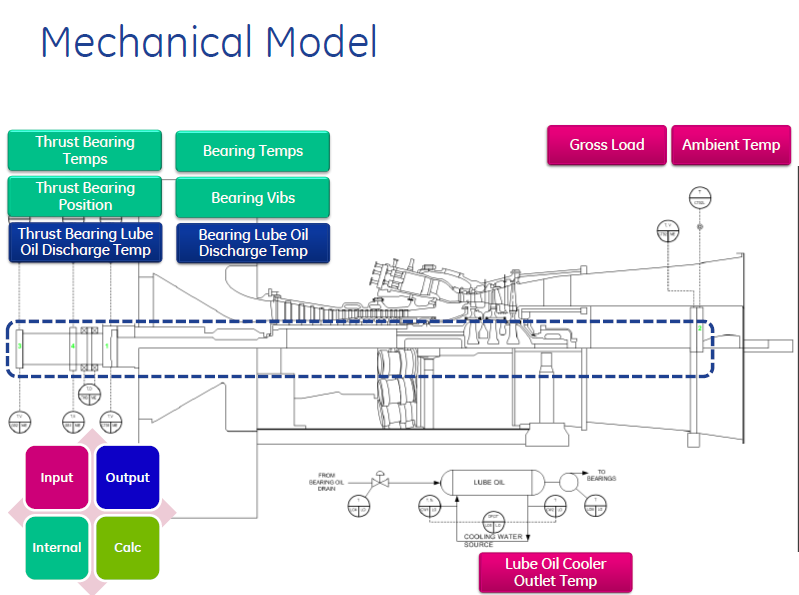

Sensor selected:
- Generator Gross Capacity 
- Turbine Lube Oil Cooler Outlet Temperature
- Turbine Bearing 1 Drain Oil Temperature
- Turbine Bearing 1 Metal Temperature
- Turbine Bearing 1X Vibration
- Turbine Bearing 1Y Vibration

## Problem Description

**Case:** ST Journal Bearing 1 - Local Bearing Problem

**Description:**

This fault indicates an abnormal change in the bearing behavior.

Primary indicators are: 
- Bearing Vibration is not normal; Bearing Metal Temperature is low; and either Lube Oil Differential Temperature is low or Lube Oil Drain Outlet Temperature low.  
- Priority 5 (lowest) is triggered when Journal Bearing Vibration is not normal or Journal Bearing Metal Temperature is not normal.  
- The priority escalates depending on the severity of the change, and the number of sensors.  
- At least 2 sensors are required to trigger Priority 1.

**Input Tags:**
- LUBE_OIL_COOLER_OIL_OUTLET_TEMP
- BRG_1_VIB_OVERALL_SEIS_1
- BRG_1_VIB_OVERALL_SEIS_2
- GROSS_LOAD
- LUBE_OIL_COOLER_OIL_OUTLET_PRESS
- BRG_1_DELTA_TEMP_CV
- AMBIENT_TEMP
- BRG_1_MTL_TEMP_1 
- BRG_1_MTL_TEMP_2
- BRG_1_MTL_TEMP_4 
- BRG_1_MTL_TEMP_3
- BRG_1_OIL_DRAIN_TEMP
- BRG_1_VIB_OVERALL_PROX_Y
- BRG_1_VIB_OVERALL_PROX_X

**Expressions:**

```
if
    (ModelIndications (MECHANICAL, [VAR, SVH], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 2.0
    and 
        (ModelIndications(MECHANICAL, [SVH, SH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 2.0
        or
        ModelIndications (MECHANICAL, [L, VL, SL, SVL], [BRG_1_OIL_DRAIN_TEMP, BRG_1_DELTA_TEMP_CV]) >= 1.0))
then
    Priority(1)
else if 
    (ModelIndications (MECHANICAL, [VAR, SVH], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 2.0
    or
    ModelIndications (MECHANICAL, [SVH, SH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 2.0
    or 
        (ModelIndications (MECHANICAL, [VAR, SVH],[BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
        and 
            (ModelIndications (MECHANICAL, [SVH, SH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
            or
            ModelIndications (MECHANICAL, [L, VL, SL, SVL],[BRG_1_OIL_DRAIN_TEMP, BRG_1_DELTA_TEMP_CV]) >= 1.0)))
then
    Priority(2)
else if 
    (ModelIndications (MECHANICAL, [VAR, SVH, AVMH],[BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
    or 
    ModelIndications (MECHANICAL, [SH, AVMH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
    or 
        (ModelIndications (MECHANICAL, [SH, VH],[BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
        and 
            (ModelIndications (MECHANICAL, [SH, SVH, VH],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
            or
            ModelIndications (MECHANICAL, [L, VL, SL, SVL],[BRG_1_OIL_DRAIN_TEMP, BRG_1_DELTA_TEMP_CV]) >= 1.0)))
then
    Priority(3)
else if 
    (ModelIndications (MECHANICAL, [SH, VH], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
    or
    ModelIndications (MECHANICAL, [H], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 2.0
    or
    ModelIndications (MECHANICAL, [VH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
    or 
        (ModelIndications (MECHANICAL, [H], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
        and
        ModelIndications (MECHANICAL, [H], [BRG_1_DELTA_TEMP_CV]) >= 1.0))
then
    Priority(4)
else if 
    (ModelIndications(MECHANICAL, [LH], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
    or
    ModelIndications (MECHANICAL, [LH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0)
then
    Priority(5)
else
    IsAssociated(MECHANICAL, [GROSS_LOAD, AMBIENT_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

# EDA

In [ ]:
# select tag
cols = ['Generator Gross Capacity',
        'Turbine Lube Oil Cooler Outlet Temperature',
        'Turbine.Bearing 1 Drain Oil Temperature',
        'Turbine.Bearing 1 Metal Temperature',
        'Turbine.Bearing 1X Vibration',
        'Turbine.Bearing 1Y Vibration']

data = data[['date']+cols]
data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine.Bearing 1 Drain Oil Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing 1X Vibration,Turbine.Bearing 1Y Vibration
0,2021-10-31 23:58:00,502.852800,45.442540,53.905110,81.089424,0.043223,0.067297
1,2021-10-31 23:57:00,503.679443,45.442540,53.900284,81.008640,0.043297,0.067446
2,2021-10-31 23:56:00,502.323547,45.441364,53.895460,81.338290,0.044264,0.066397
3,2021-10-31 23:55:00,507.118744,45.437023,53.892097,81.496216,0.044535,0.066694
4,2021-10-31 23:54:00,505.777863,45.432680,53.892097,81.158640,0.044220,0.066168


## Data Information

In [ ]:
# check data shape
data.shape

(132479, 7)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132479 entries, 0 to 132478
Data columns (total 7 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   date                                        132479 non-null  object 
 1   Generator Gross Capacity                    126142 non-null  float64
 2   Turbine Lube Oil Cooler Outlet Temperature  126110 non-null  float64
 3   Turbine.Bearing 1 Drain Oil Temperature     126655 non-null  float64
 4   Turbine.Bearing 1 Metal Temperature         126133 non-null  float64
 5   Turbine.Bearing 1X Vibration                126153 non-null  float64
 6   Turbine.Bearing 1Y Vibration                126154 non-null  float64
dtypes: float64(6), object(1)
memory usage: 7.1+ MB


In [ ]:
# convert date to datetime
data['date'] = pd.to_datetime(data['date'])

In [ ]:
# data date
print(f"Minimum date: {data['date'].min()}")
print(f"Maximum date: {data['date'].max()}")
print(f"Interval: {data['date'][0] - data['date'][1]}")

Minimum date: 2021-08-01 00:00:00
Maximum date: 2021-10-31 23:58:00
Interval: 0 days 00:01:00


## Missing Value

In [ ]:
# check missing value
data.isnull().sum()

date                                             0
Generator Gross Capacity                      6337
Turbine Lube Oil Cooler Outlet Temperature    6369
Turbine.Bearing 1 Drain Oil Temperature       5824
Turbine.Bearing 1 Metal Temperature           6346
Turbine.Bearing 1X Vibration                  6326
Turbine.Bearing 1Y Vibration                  6325
dtype: int64

In [ ]:
# check percentage missing value
data.isnull().sum()/len(data)*100

date                                          0.000000
Generator Gross Capacity                      4.783400
Turbine Lube Oil Cooler Outlet Temperature    4.807554
Turbine.Bearing 1 Drain Oil Temperature       4.396168
Turbine.Bearing 1 Metal Temperature           4.790193
Turbine.Bearing 1X Vibration                  4.775096
Turbine.Bearing 1Y Vibration                  4.774342
dtype: float64

In [ ]:
# imputate data with interpolation
for col in cols:
    data[col] = data[col].interpolate(method='linear')

In [ ]:
data.isnull().sum()

date                                          0
Generator Gross Capacity                      0
Turbine Lube Oil Cooler Outlet Temperature    0
Turbine.Bearing 1 Drain Oil Temperature       0
Turbine.Bearing 1 Metal Temperature           0
Turbine.Bearing 1X Vibration                  0
Turbine.Bearing 1Y Vibration                  0
dtype: int64

## Descriptive Statistics

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Generator Gross Capacity,132479.0,537.267758,138.980322,0.000000,565.072366,584.556300,589.101531,610.248900
Turbine Lube Oil Cooler Outlet Temperature,132479.0,44.676840,2.905018,32.804650,44.422540,45.485560,46.023996,47.335740
Turbine.Bearing 1 Drain Oil Temperature,132479.0,52.035455,6.238847,27.052761,52.859493,53.893400,54.440229,56.443672
Turbine.Bearing 1 Metal Temperature,132479.0,81.662989,15.495650,-2450.339360,83.569730,84.963120,86.049395,810.952332
Turbine.Bearing 1X Vibration,132479.0,0.052605,0.013405,0.000000,0.052810,0.055899,0.058191,0.139720
Turbine.Bearing 1Y Vibration,132479.0,0.046700,0.012049,0.001000,0.045302,0.046999,0.049428,0.150720


Mean: 537.2677576235909, Median: 584.5563


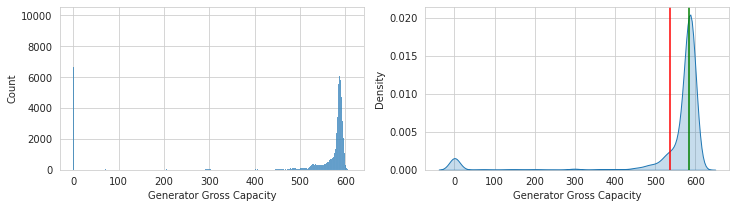

Mean: 44.676840174651595, Median: 45.48556


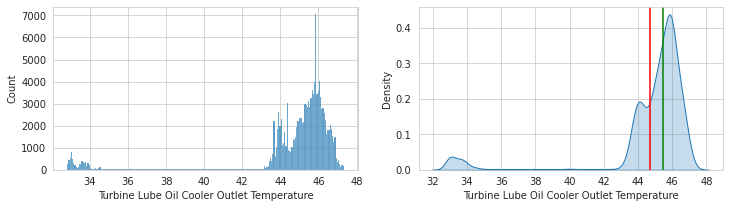

Mean: 52.035454863794364, Median: 53.8934


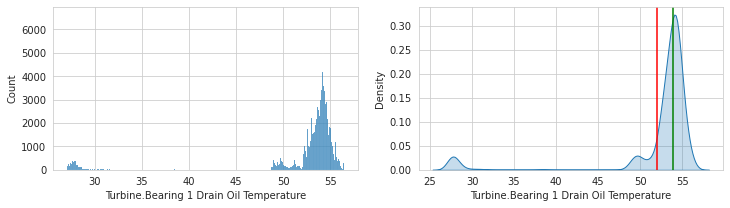

Mean: 81.6629893556887, Median: 84.96311999999999


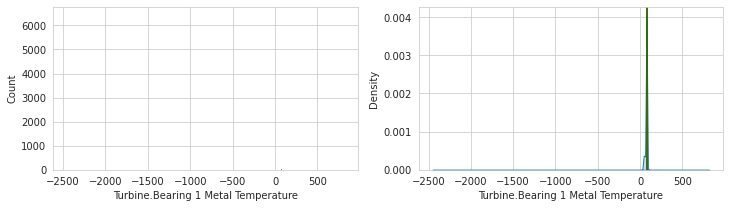

Mean: 0.05260513110483445, Median: 0.055898957


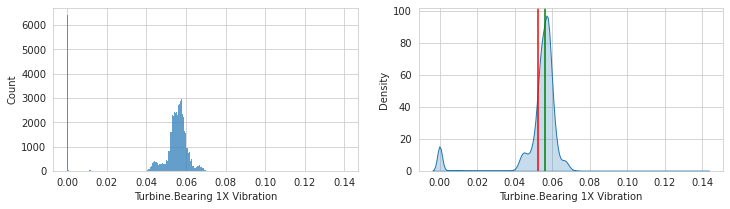

Mean: 0.046699521208195593, Median: 0.046999394900000005


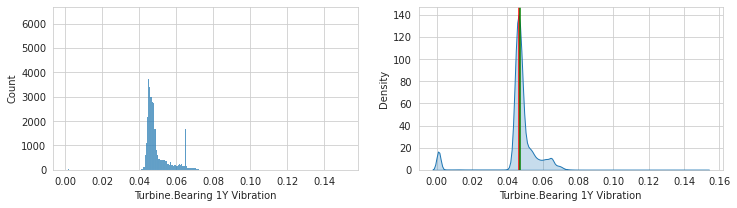

In [ ]:
# distribution
for i,col in enumerate(cols):
    fig, axes = plt.subplots(1,2,figsize=(12,3))

    # histogram plot
    sns.histplot(data=data, x=col, ax=axes[0])

    # get mean and median
    mean = data[col].mean()
    median = data[col].median()
    print(f"Mean: {mean}, Median: {median}")

    sns.kdeplot(data=data, x=col, ax=axes[1], fill=True)
    axes[1].axvline(x=mean, color='red')
    axes[1].axvline(x=median, color='green')
    plt.show();

## Plotting

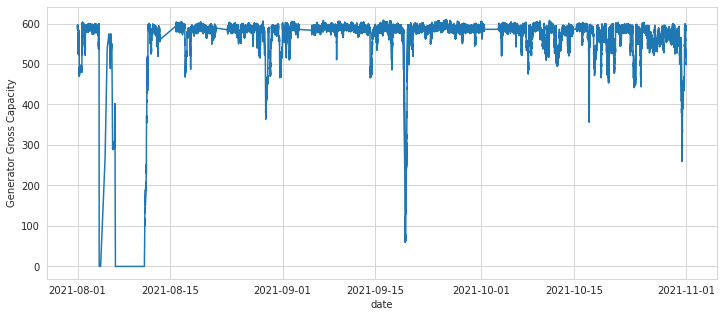

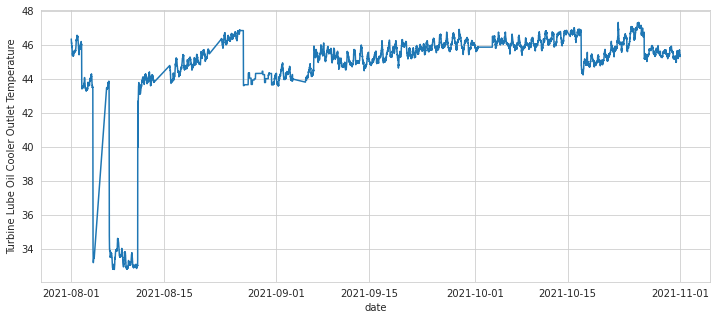

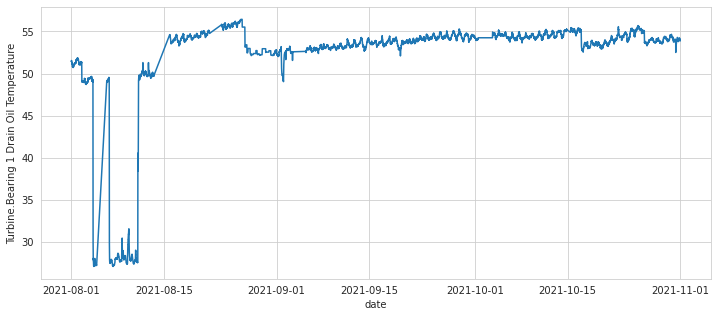

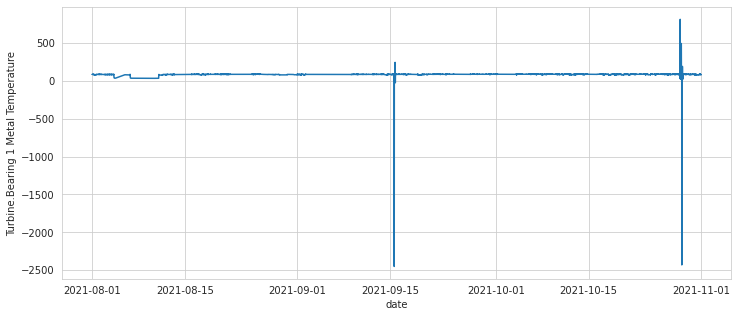

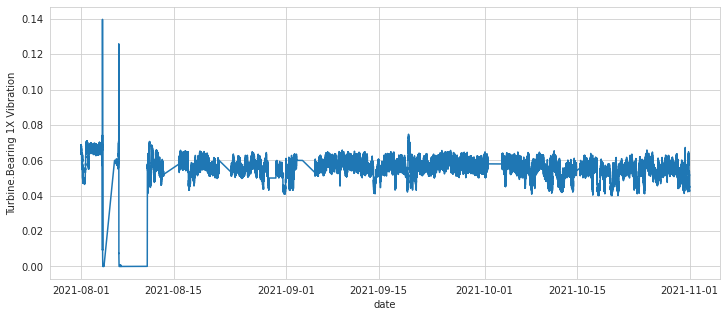

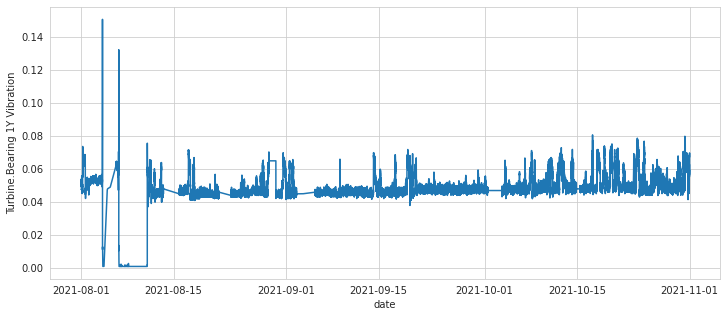

In [ ]:
for col in cols:
    plt.figure(figsize=(12,5))
    sns.lineplot(data=data, x="date", y=col)
    plt.show();

# Modeling

## VBM

### Create model

In [ ]:
def scipy_distance(vector1, vector2, dist='euclidean'):
    if dist == 'euclidean':
        return distance.euclidean(vector1, vector2)
    elif dist == 'braycurtis':
        return distance.braycurtis(vector1, vector2)
    elif dist == 'correlation':
        return distance.correlation(vector1, vector2)
    elif dist == 'canberra':
        return distance.canberra(vector1, vector2)
    elif dist == 'chebyshev':
        return distance.chebyshev(vector1, vector2)
    elif dist == 'cityblock':
        return distance.cityblock(vector1, vector2)
    elif dist == 'minkowski':
        return distance.minkowski(vector1, vector2)
    elif dist == 'sqeuclidean':
        return distance.sqeuclidean(vector1, vector2)
    elif dist == 'cosine':
        return distance.cosine(vector1, vector2)

In [ ]:
# function to create a dynamic matrix 
def create_dynamic_matrix(matrix):
    
    # get current actual
    current_actual = matrix[:, -1]

    # calculate similarity
    sim_vec = []
    for i in range(matrix.shape[1]):
        sim = 1 - scipy_distance(current_actual, matrix[:, i], dist='canberra')
        sim_vec.append(sim)
    
    # sort the matrix
    n = 10
    top = np.sort(np.array(sim_vec).argsort()[::-1][:n])
    top_sim_vec = np.array(sim_vec)[top]

    # create dynamic matrix
    dynamic_matrix = matrix[:, top]

    # calculate weight
    weight = np.array([s/np.sum(top_sim_vec) for s in top_sim_vec])

    return dynamic_matrix, weight

def vbm(dynamic_matrix, weight):
    return np.dot(dynamic_matrix, weight.T)

### Prepare data

In [ ]:
data.head()

,date,Generator Gross Capacity,Turbine Lube Oil Cooler Outlet Temperature,Turbine.Bearing 1 Drain Oil Temperature,Turbine.Bearing 1 Metal Temperature,Turbine.Bearing 1X Vibration,Turbine.Bearing 1Y Vibration
0,2021-10-31 23:58:00,502.852800,45.442540,53.905110,81.089424,0.043223,0.067297
1,2021-10-31 23:57:00,503.679443,45.442540,53.900284,81.008640,0.043297,0.067446
2,2021-10-31 23:56:00,502.323547,45.441364,53.895460,81.338290,0.044264,0.066397
3,2021-10-31 23:55:00,507.118744,45.437023,53.892097,81.496216,0.044535,0.066694
4,2021-10-31 23:54:00,505.777863,45.432680,53.892097,81.158640,0.044220,0.066168


In [ ]:
big_matrix = data[cols].values.T
big_matrix.shape

(6, 132479)

### Predict

In [ ]:
%%time
# Estimate t+1 sensor data
dim_matrix = 400
x_estimates_vbm = []
x_actuals = []

for i in range(big_matrix.shape[1]-dim_matrix):
    matrix = big_matrix[:, i:i+dim_matrix]
    
    # create dynamic matrix
    dm, w = create_dynamic_matrix(matrix)

    # estimate data at t+1 with input data at t
    x_est = vbm(dm, w)

    # get actual to calculate evaluation metric
    x_actual = big_matrix[:, i+dim_matrix] 

    x_estimates_vbm.append(x_est)
    x_actuals.append(x_actual)

# convert to numpy array
x_estimates_vbm = np.array(x_estimates_vbm)
x_actuals = np.array(x_actuals)

CPU times: user 33min 46s, sys: 1min 2s, total: 34min 48s
Wall time: 33min 53s


### Evaluate

In [ ]:
# evaluate prognostic
print(f"MSE: {mean_squared_error(x_actuals, x_estimates_vbm)}")
print(f"RMSE: {np.sqrt(mean_squared_error(x_actuals, x_estimates_vbm))}")

MSE: 89965.34316204145
RMSE: 299.9422330417


Generator Gross Capacity
RMSE: 734.5029185084119


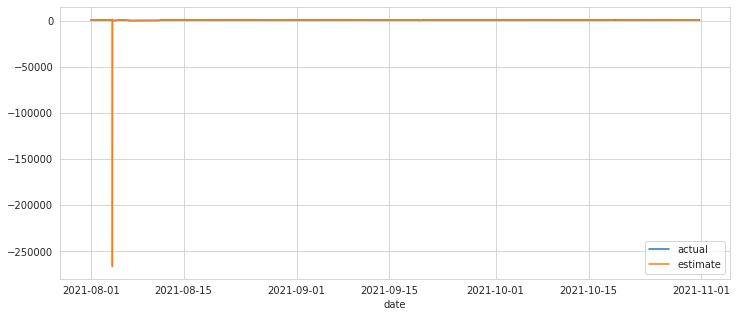

Turbine Lube Oil Cooler Outlet Temperature
RMSE: 1.5441673308628436


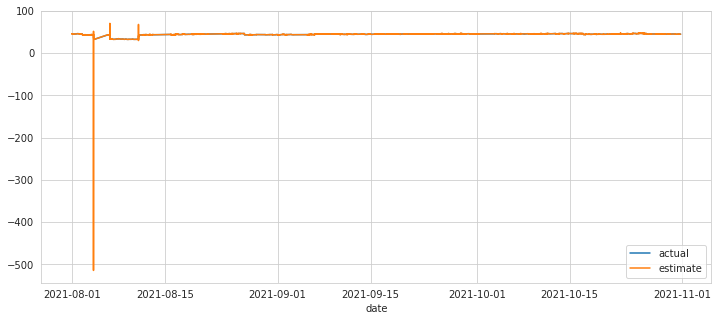

Turbine.Bearing 1 Drain Oil Temperature
RMSE: 8.945964050353089


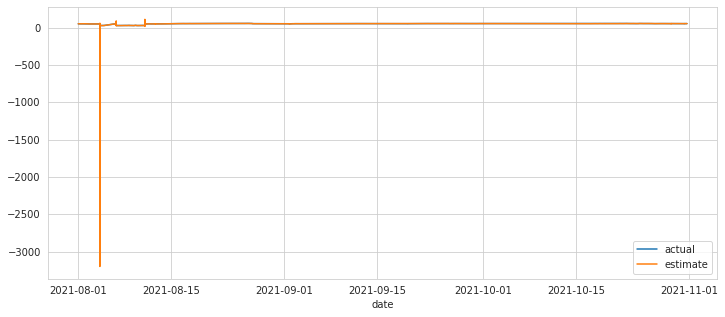

Turbine.Bearing 1 Metal Temperature
RMSE: 14.666517268875957


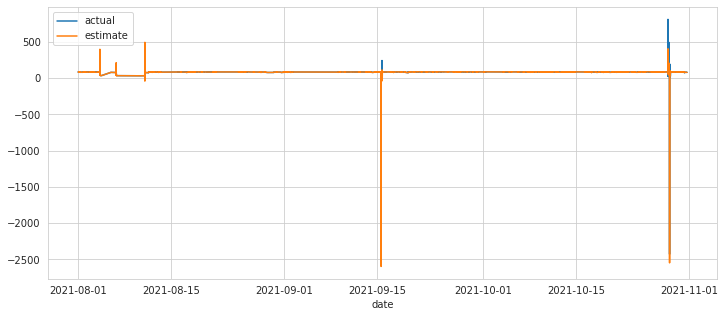

Turbine.Bearing 1X Vibration
RMSE: 0.008320247159085442


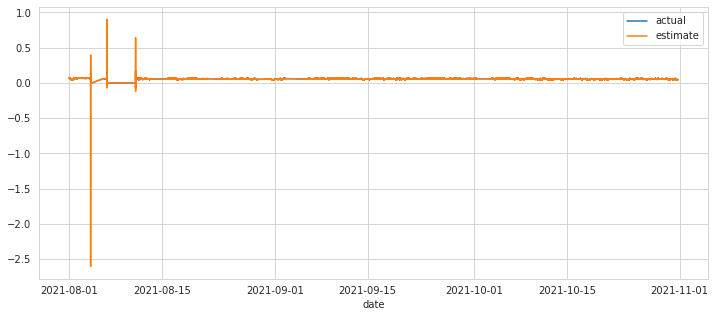

Turbine.Bearing 1Y Vibration
RMSE: 0.012300874828152434


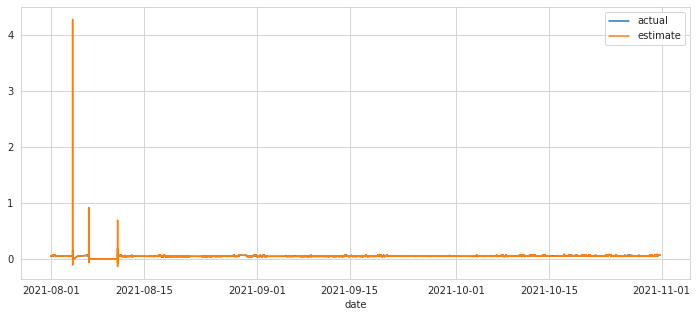

In [ ]:
# calculate RMSE for each sensor data
for i,col in enumerate(cols):
    plt.figure(figsize=(12,5))
    print(col)
    print(f"RMSE: {np.sqrt(mean_squared_error(x_actuals[:,i], x_estimates_vbm[:,i]))}")
    sns.lineplot(x=data['date'][400:], y=x_actuals[:,i])
    sns.lineplot(x=data['date'][400:], y=x_estimates_vbm[:,i])
    plt.legend(['actual','estimate'])
    plt.show();

# Diagnostic

Reference:
- https://www.ge.com/digital/documentation/predix-apm/latest/r_apm_smartsignal_exp_syn_diagnostics_functions.html

**Expressions:**

```
if
    (ModelIndications (MECHANICAL, [VAR, SVH], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 2.0
    and 
        (ModelIndications(MECHANICAL, [SVH, SH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 2.0
        or
        ModelIndications (MECHANICAL, [L, VL, SL, SVL], [BRG_1_OIL_DRAIN_TEMP, BRG_1_DELTA_TEMP_CV]) >= 1.0))
then
    Priority(1)
else if 
    (ModelIndications (MECHANICAL, [VAR, SVH], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 2.0
    or
    ModelIndications (MECHANICAL, [SVH, SH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 2.0
    or 
        (ModelIndications (MECHANICAL, [VAR, SVH],[BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
        and 
            (ModelIndications (MECHANICAL, [SVH, SH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
            or
            ModelIndications (MECHANICAL, [L, VL, SL, SVL],[BRG_1_OIL_DRAIN_TEMP, BRG_1_DELTA_TEMP_CV]) >= 1.0)))
then
    Priority(2)
else if 
    (ModelIndications (MECHANICAL, [VAR, SVH, AVMH],[BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
    or 
    ModelIndications (MECHANICAL, [SH, AVMH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
    or 
        (ModelIndications (MECHANICAL, [SH, VH],[BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
        and 
            (ModelIndications (MECHANICAL, [SH, SVH, VH],[BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
            or
            ModelIndications (MECHANICAL, [L, VL, SL, SVL],[BRG_1_OIL_DRAIN_TEMP, BRG_1_DELTA_TEMP_CV]) >= 1.0)))
then
    Priority(3)
else if 
    (ModelIndications (MECHANICAL, [SH, VH], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
    or
    ModelIndications (MECHANICAL, [H], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 2.0
    or
    ModelIndications (MECHANICAL, [VH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
    or 
        (ModelIndications (MECHANICAL, [H], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0
        and
        ModelIndications (MECHANICAL, [H], [BRG_1_DELTA_TEMP_CV]) >= 1.0))
then
    Priority(4)
else if 
    (ModelIndications(MECHANICAL, [LH], [BRG_1_VIB_OVERALL_PROX_X, BRG_1_VIB_OVERALL_SEIS_1, BRG_1_VIB_OVERALL_PROX_Y, BRG_1_VIB_OVERALL_SEIS_2]) >= 1.0
    or
    ModelIndications (MECHANICAL, [LH], [BRG_1_MTL_TEMP_1, BRG_1_MTL_TEMP_2, BRG_1_MTL_TEMP_3, BRG_1_MTL_TEMP_4]) >= 1.0)
then
    Priority(5)
else
    IsAssociated(MECHANICAL, [GROSS_LOAD, AMBIENT_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_TEMP, LUBE_OIL_COOLER_OIL_OUTLET_PRESS])
```

## Model Tag Rules 


https://www.ge.com/digital/documentation/predix-apm/latest/r_apm_smartsignal_exp_syn_logical_functions.html


Function: `WindowRatio()`
- Description: This function looks at a window of data and compares it to a threshold. If the number of true comparisons is greater than or equal to the `trueSize` than `windowRatio` will return `true` otherwise it will return `false`.
    - Integer `trueSize`, The trueSize specifies the number of true comparison must be found in the window (specified in values) for windowRatio to return `True`. When a `NaN` present in values the `TrueSize` is divided by the window to create a ratio (or percentage) for which 
    - List values, A list of tag values to be compared to the threshold. The window size is specified by the size of the list. E.g. `Tag.Actual(20)` is a window of 20 
    - String comparisonOperator,  Specifies how to compare the values to the threshold. Valid options are: `=`, `>`, `<`, `>=`, `<=`, `!=`. The operator must be in quotes, `“=”`
    - Float threshold, A threshold that the values will be compared to
    - Integer requiredGoodSize, The required number of numeric values. If the number of numeric (non `NaN`s) in values is less than this value `windowRatio` will return `false`. Typically `requiredGoodSize` is about `one half the window size.`
- Example: `WindowRatio(17, Tag.ResidualIndicationPositive(18), ”=”, 1, 9)`

### Actual High Model (AVMH)

**Expressions:**

```
WindowRatio(5, Tag.Actual(6), ">=", Tag.ActualHigh, 4) And 
(Tag.ActiveInModel) And 
(Tag.Actual >= Tag.ActualHigh)
```

### High (H)

**Expressions:**

```
(WindowRatio(16, Tag.ResidualIndicationPositive(18), "=", 1, 9)) And 
(Tag.Residual >= Tag.ResidualPositiveThreshold)
```

### Low (L)

Expressions:
```
(WindowRatio(16, Tag.ResidualIndicationNegative(18), "=", 1, 9)) And 
(Tag.Residual <= Tag.ResidualNegativeThreshold)
```


### Long High (LH)

Expressions:
```
WindowRatio(45, Tag.ResidualIndicationPositive(48), "=", 1, 24) And 
(Tag.Residual >= Tag.ResidualPositiveThreshold)
```

### Step High (SH)

**Expressions:**
```
IsStep(Tag.Actual(7), 2.5* Tag.ResidualPositiveThreshold, NaN()) And
(Tag.Residual>(1.5* Tag.ResidualPositiveThreshold))
```

### Step Low (SL)

Expressions:
```
Isstep(Tag.Actual(7), NaN(), 2.5* Tag.ResidualNegativeThreshold) And 
(Tag.Residual < (1.5* Tag.ResidualNegativeThreshold))
```

### Step Very Low (SVL)

Expressions:
```
Isstep(Tag.Actual(7), NaN(), 3.0 * Tag.ResidualNegativeThreshold) And 
(Tag.Residual < (2.0*Tag.ResidualNegativeThreshold)) And 
Tag.ResidualIndicationNegative = 1
```

### Step Very High (SVH)

**Expressions:**
```
IsStep(Tag.Actual(7), 3.0 * Tag.ResidualPositiveThreshold, NaN()) And 
(Tag.Residual > (2.0 * Tag.ResidualPositiveThreshold)) And 
Tag.ResidualIndicationPositive = 1
```

### Very High (VH)

Expressions:
```
(WindowRatio(8, Tag.ResidualIndicationPositive(9), "=", 1, 6)) And 
(WindowRatio(6, Tag.Residual(9), ">=", (2.0 * TagResidualPositiveThreshold), 6)) And
(Tag.Residual >= (2.0 * Tag.ResidualPositiveThreshold))
```

### Very Low (VL)

Expressions:
```
(WindowRatio(8, Tag.ResidualIndicationNegative(9), "=", 1, 6)) And 
(WindowRatio(6, Tag.Residual(9), "<=", (2.0 * Tag.ResidualNegativeThreshold), 6)) And 
(Tag.Residual <= (2.0 * Tag.ResidualNegativeThreshold))
```

### Variance (VAR)

Expressions:
```
(Variance(Tag.Residual(18)) > (4*Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)])^2))
And 
WindowRatio(2, Tag.Residual(6),"">="",Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)]),4)
And 
WindowRatio(2,Tag.Residual(6),""<="",(-1)*Minimum([abs(Tag.ResidualPositiveThreshold), abs(Tag.ResidualNegativeThreshold)]),4)
```